In [5]:
# Pandas
import pandas as pd

#Preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

# Pipeline
from sklearn.pipeline import Pipeline   # Sequentially apply a list of transformations
from sklearn.compose import ColumnTransformer # Applies in parallel transformations to columns
from sklearn.preprocessing import FunctionTransformer # it makes functions compatible with scikit-learn pipelines

# Grid search 
from sklearn.model_selection import GridSearchCV

# pipeline visualization (only if sklearn version = 0.23.1)
from sklearn import set_config
set_config(display='diagram')

# The Titanic dataset

In [6]:
titanic_data = pd.read_csv('data/titanic.csv')

**Numerical features**:
- Age
- Fare
- Pclass (passenger class)
- SibSp (number of siblings / spouses aboard the Titanic)
- Parch (number of parents / children aboard the Titanic)

**Categorical features**:
- Sex
- Ticket
- Cabin
- Embarked (Port of Embarkation: C, Q, and S)

In [57]:
# valuecounts 
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Feature Engineering

Often, you will want to convert an existing Python function into a transformer to assist in data cleaning or processing. You can implement a transformer from an arbitrary function with `FunctionTransformer.`

**Title feature:** Let's write a function that extract the title (Mr, Mrs, Miss, Dr, etc) from the name

In [58]:
titanic.Name.head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [59]:
titanic.Name[0].split(",")[1].split('.')[0].strip()

'Mr'

Let's create a feature that extracts the title from the name (i.e. Mr, Mrs, Miss, Dr, etc)

In [61]:
# Title feature
titles = titanic_data.Name.apply(lambda x: x.split(",")[1].split(".")[0].strip())
titles

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Name, Length: 891, dtype: object

<Axes: xlabel='Name'>

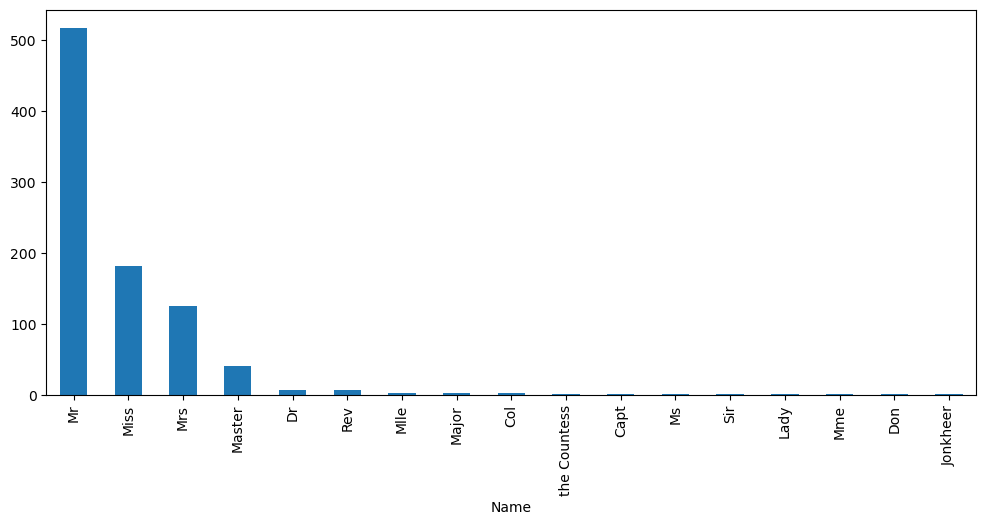

In [62]:
titles.value_counts().plot(kind='bar',figsize=(12,5))

Since there are many titles, we will group them into 4 categories: Mr, Miss, Mrs, Master, Dr., Rev, and convert the remaining titles to 'Other'.

In [63]:
# replace the less common titles with 'Other'
most_common_titles = titles.value_counts().head(6).index.to_list()
titles[~titles.isin(most_common_titles)] = 'Other'

<Axes: xlabel='Name'>

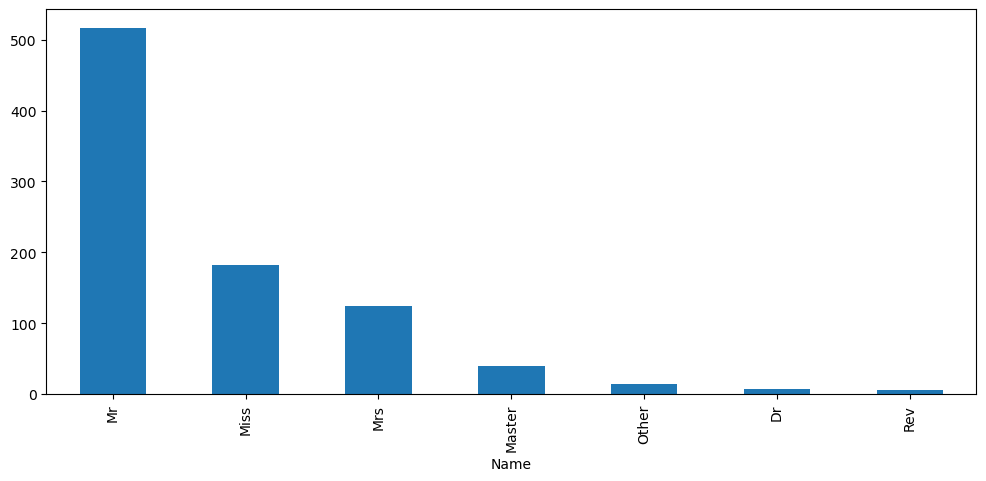

In [64]:
titles.value_counts().plot(kind='bar',figsize=(12,5))

Below I define a function to use in the pipeline during feature transformation.

In [66]:
def get_title(dataframe):
    '''
    Extract the title from the name column and replace the less common titles with 'Other'
    '''
    df = dataframe.copy()
    df['Title'] = df.Name.apply(lambda x: x.split(",")[1].split(".")[0].strip())
    df.loc[~df.Title.isin(most_common_titles),'Title'] = 'Other'
    return df

In [67]:
# check that it works
get_title(titanic_data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


In [23]:
# check that it works
get_title(titanic_data).Title.value_counts()

Title
Mr        517
Miss      182
Mrs       125
Master     40
Other      14
Dr          7
Rev         6
Name: count, dtype: int64

I will now define a feature that computes the family size of a passenger. The family size is the sum of the number of siblings/spouses and the number of parents/children, plus one (the passenger themselves).

In [68]:
# family size
family_size = titanic_data.SibSp+titanic_data.Parch+1
family_size

0      2
1      2
2      1
3      2
4      1
      ..
886    1
887    1
888    4
889    1
890    1
Length: 891, dtype: int64

In [69]:
def get_family_size(dataframe):
    df = dataframe.copy()
    df['Family_size'] = df.SibSp + df.Parch + 1
    return df

In [70]:
# check that it works
get_family_size(titanic_data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


Create a function transformer that will act as our processor in the pipeline.

In [71]:
# Functions for the pipeline
family_size_processor = FunctionTransformer(get_family_size)
title_processor = FunctionTransformer(get_title)

We will use them later in the pipeline.

### Scaling and Imputing

Using a series of pipelines and a column transformer, we can apply different transformations to different columns. In this case, we will scale the numerical features and impute missing values.

Imputing is the process of replacing missing values with a valid value. In this case, we will replace missing values with the median of the column.

In [74]:
# numerical features pipeline: impute+scale
numeric_features = ['Age', 'Fare','Family_size', 'Pclass']
numeric_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

Then impute and encode the categorical features.

In [75]:
# categorical_features pipeline: impute+encode
categorical_features = ['Embarked', 'Sex','Title']
categorical_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())])

The ColumnTransformer applies transformers to columns of an array or pandas DataFrame.  It will be used in the Pipeline.

In [76]:
feature_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_processor, numeric_features),
        ('cat', categorical_processor, categorical_features)
    ],
         remainder='drop') # drop 'Name', 'SibSp', 'Parch' columns (they were not included in the numeric or categorical features and are used in the family_size feature)

### Random Forest Classifier

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

In [78]:
pipe = Pipeline(steps=[('get family_size', family_size_processor),
                           ('get title', title_processor),
                           ('preprocessor', feature_processor),
                        #    ('poly_features', PolynomialFeatures(degree=2)),
                           ('clf',rf_clf)   
                          ])
pipe

Pipeline(steps=[('get family_size',
                 FunctionTransformer(func=<function get_family_size at 0x7b50825039d0>)),
                ('get title',
                 FunctionTransformer(func=<function get_title at 0x7b50c9ccfee0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'Family_size',
                                                   'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Embarked', 'Sex',
                                                   'Title'])])),
                ('clf', RandomForestClassifier())])

## Grid search for hyperparameter tuning

In [80]:
# feature matrix/ target vector
# Not using Ticket since it is a complex string that is hard to encode
feature_cols = ['Name','Age','Fare','Sex','Embarked','Pclass','SibSp','Parch']
X = titanic_data[feature_cols] 
y = titanic_data.Survived

In [81]:
# reload the data
titanic_data = pd.read_csv('data/titanic.csv')
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [82]:
# train/test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [83]:
param_grid = { 
    'clf__n_estimators': list(range(100,400,50)),
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__max_depth' : [4,5,6,7,8],
    'clf__criterion' :['gini', 'entropy']
}

In [84]:
# instantiate and fit the grid
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


KeyboardInterrupt: 

In [40]:
# view the results
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']]

,mean_test_score,params
0,0.764948,"{'clf__n_neighbors': 1, 'clf__weights': 'unifo..."
1,0.764948,"{'clf__n_neighbors': 1, 'clf__weights': 'dista..."
2,0.784487,"{'clf__n_neighbors': 2, 'clf__weights': 'unifo..."
3,0.760448,"{'clf__n_neighbors': 2, 'clf__weights': 'dista..."
4,0.814337,"{'clf__n_neighbors': 3, 'clf__weights': 'unifo..."
5,0.788919,"{'clf__n_neighbors': 3, 'clf__weights': 'dista..."
6,0.802307,"{'clf__n_neighbors': 4, 'clf__weights': 'unifo..."
7,0.791904,"{'clf__n_neighbors': 4, 'clf__weights': 'dista..."
8,0.809837,"{'clf__n_neighbors': 5, 'clf__weights': 'unifo..."
9,0.788919,"{'clf__n_neighbors': 5, 'clf__weights': 'dista..."


In [41]:
# best hyper-parameters
grid.best_params_

{'clf__n_neighbors': 18, 'clf__weights': 'uniform'}

In [42]:
# best accuracy
grid.best_score_

0.8204206241519675

In [43]:
# best predictor
best_clf = grid.best_estimator_

# Test the model

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [45]:
y_test_pred = best_clf.predict(X_test)

In [46]:
confusion_matrix(y_test,y_test_pred)

array([[134,  15],
       [ 21,  53]])

In [47]:
accuracy_score(y_test,y_test_pred)

0.8385650224215246

## A fake passenger

In [48]:
titanic.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [49]:
# Making predictions: Would I have survived the Titanic disaster? 0 = No, 1 = Yes
Javier = pd.DataFrame({
                    'Name':['Perez-Alvaro, Mr. Javier','Perez-Alvaro, Dr. Javier'],
                    'Age': [35, 35],
                    'Fare': [9,500],
                    'Sex': ['male','male'],
                    'Embarked': ['S','C'],
                    'Pclass':[3,1],
                    'SibSp': [0,0],
                    'Parch': [0,0],
                   })
Javier

,Name,Age,Fare,Sex,Embarked,Pclass,SibSp,Parch
0,"Perez-Alvaro, Mr. Javier",35,9,male,S,3,0,0
1,"Perez-Alvaro, Dr. Javier",35,500,male,C,1,0,0


In [50]:
best_clf.predict(Javier)

array([0, 1])

<Axes: >

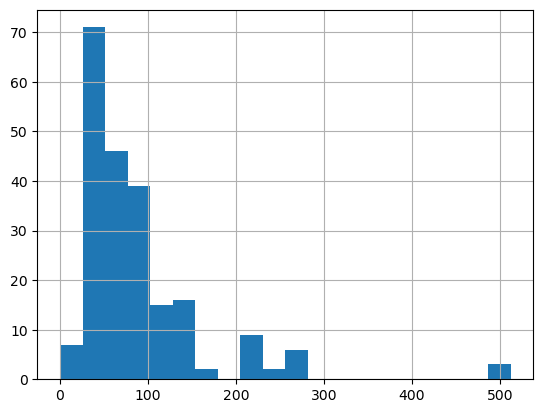

In [51]:
titanic[titanic.Pclass==1].Fare.hist(bins=20)

In [52]:
titanic[titanic.Pclass==1].Embarked.value_counts()

Embarked
S    127
C     85
Q      2
Name: count, dtype: int64

<Axes: >

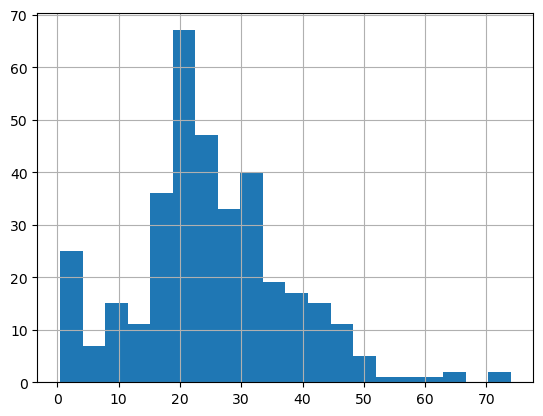

In [53]:
titanic[titanic.Pclass==3].Age.hist(bins=20)